# Pipeline: Lane finding on images
We show an end to end processing pipeline from raw uncalibrated images to lanes including lane curvature etc

## Distortion correction
Read in raw uncalibrated images and correct for camera lens distortions

In [1]:
import cv2
import pickle, pprint

# Camera matrix and distortion coefficients obtained in 'Camera Calibration' notebook
calib_file = open('camera_calib.pickle','rb')
calib_dict = pickle.load(calib_file)
print('Read camera calibration objects:')
pprint.pprint(calib_dict)
calib_file.close()

#cameraMatrix = [[1.15777942e+03, 0.00000000e+00, 6.67111049e+02],
# [0.00000000e+00, 1.15282305e+03, 3.86129069e+02],
# [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]
#distCoeffs = [[-0.24688833, -0.02372814, -0.00109843, 0.00035105, -0.00259138]]

def cal_undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist)
    return undist


Read camera calibration objects:
{'cameraMatrix': array([[1.15777942e+03, 0.00000000e+00, 6.67111049e+02],
       [0.00000000e+00, 1.15282305e+03, 3.86129069e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'distCoeffs': array([[-0.24688833, -0.02372814, -0.00109843,  0.00035105, -0.00259138]])}


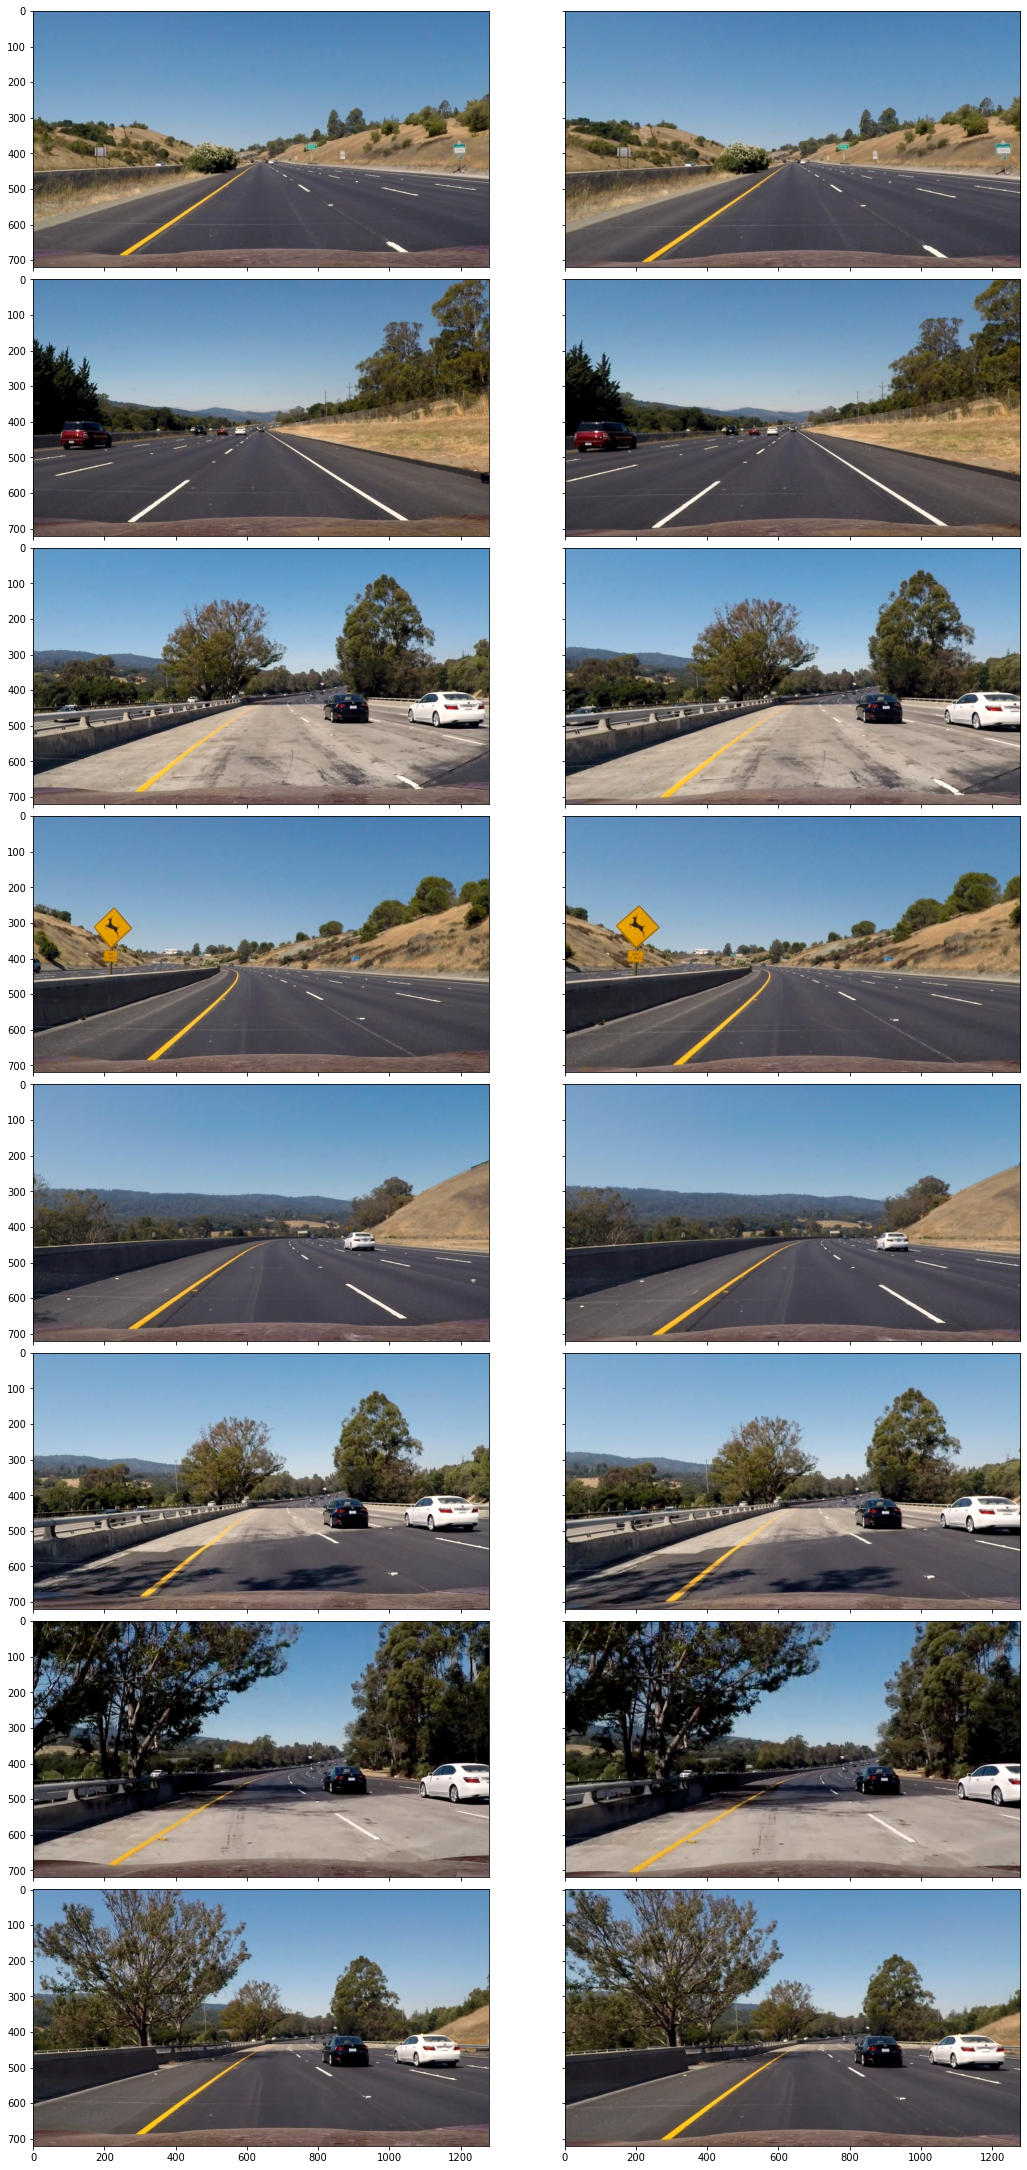

In [2]:
# Apply on test images
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

# Get all file names
path = 'test_images'
file_names = [join(path,f) for f in listdir(path) if (isfile(join(path, f)) and (".jpg" in f))]

# Create canvas to thow original and undistorted images
fig, axes = plt.subplots(nrows=len(file_names), ncols=2,sharex=True,sharey=True,figsize=(15,30))
plt.tight_layout(pad=0.2)

for i, file_name in enumerate(file_names):
    
    # Read image
    img = cv2.imread(file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Undistort
    undistorted = cal_undistort(img, calib_dict['cameraMatrix'], calib_dict['distCoeffs'])

    # Show
    axes[i][0].imshow(img)
    axes[i][1].imshow(undistorted)
    


## Lane Pixels
We use a combination of various gradients, color transforms, et cetera to identify pixels which belong to lane markings

In [3]:
import numpy as np
import cv2

# Function to select pixels belonging to lanes
def lane_pixels(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary,combined_binary
    

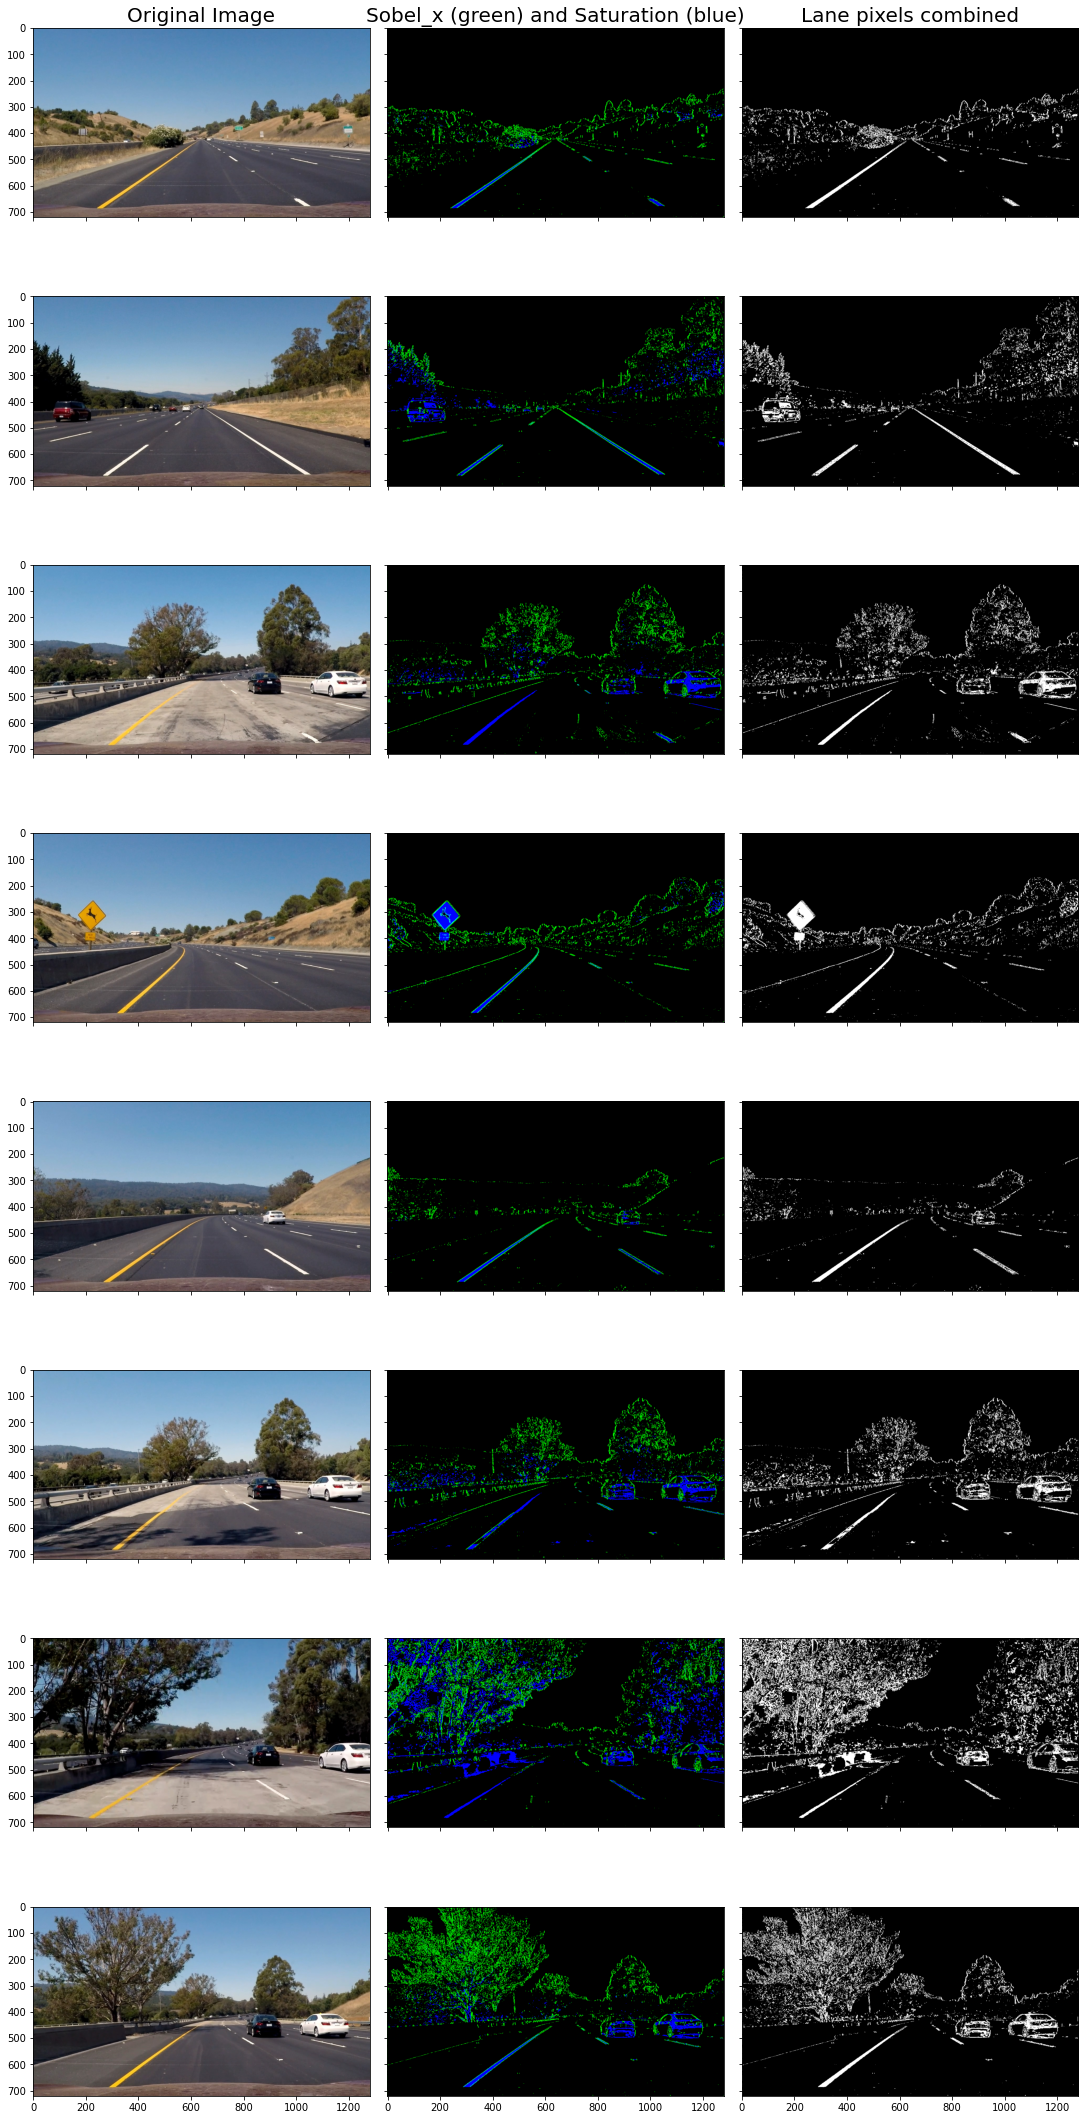

In [4]:
# Apply on test images
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

# Get all file names
path = 'test_images'
file_names = [join(path,f) for f in listdir(path) if (isfile(join(path, f)) and (".jpg" in f))]

# Create canvas to thow original and undistorted images
fig, axes = plt.subplots(nrows=len(file_names), ncols=3,sharex=True,sharey=True,figsize=(15,30))
plt.tight_layout(pad=0.2)
axes[0][0].set_title('Original Image', fontsize=20)
axes[0][1].set_title('Sobel_x (green) and Saturation (blue)', fontsize=20)
axes[0][2].set_title('Lane pixels combined', fontsize=20)
    
for i, file_name in enumerate(file_names):
    
    # Read image
    img = cv2.imread(file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Undistort
    sep, combined = lane_pixels(img,s_thresh=(180, 255), sx_thresh=(30, 120))

    # Show
    axes[i][0].imshow(img)
    axes[i][1].imshow(sep)
    axes[i][2].imshow(combined,cmap='gray')
